In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Real Data (target distribution):
tensor([[1.0000, 1.0000],
        [0.9000, 1.1000],
        [1.1000, 0.9000],
        [1.0000, 0.9500]])

Mean: [1.0, 0.987500011920929]


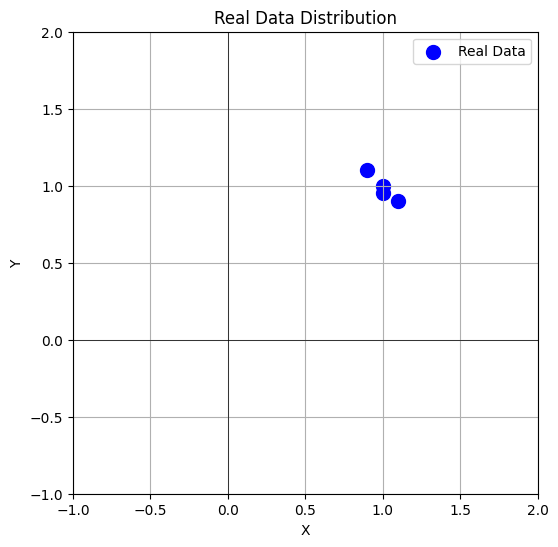

In [2]:
# Real data: Points on a simple pattern
# We want the generator to learn to produce points near [1, 1]

real_data = torch.tensor([
    [1.0, 1.0],
    [0.9, 1.1],
    [1.1, 0.9],
    [1.0, 0.95],
], dtype=torch.float32)

print("Real Data (target distribution):")
print(real_data)
print(f"\nMean: {real_data.mean(dim=0).tolist()}")

# Visualize
plt.figure(figsize=(6, 6))
plt.scatter(real_data[:, 0].numpy(), real_data[:, 1].numpy(), 
           c='blue', s=100, label='Real Data', marker='o')
plt.xlim(-1, 2)
plt.ylim(-1, 2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Real Data Distribution')
plt.legend()
plt.grid(True)
plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
plt.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
plt.show()

In [3]:
def sigmoid(x):
    """Sigmoid activation."""
    return 1 / (1 + torch.exp(-torch.clamp(x, -50, 50)))

def sigmoid_derivative(x):
    """Derivative of sigmoid."""
    s = sigmoid(x)
    return s * (1 - s)

def tanh(x):
    """Tanh activation."""
    return torch.tanh(x)

def tanh_derivative(x):
    """Derivative of tanh."""
    return 1 - torch.tanh(x) ** 2

def relu(x):
    """ReLU activation."""
    return torch.maximum(x, torch.tensor(0.0))

def relu_derivative(x):
    """Derivative of ReLU."""
    return (x > 0).float()

print("Activation functions defined!")

Activation functions defined!


In [4]:
class Generator:
    """
    Generator Network.
    Maps random noise to data space.
    """
    def __init__(self, noise_dim=2, hidden_dim=4, output_dim=2):
        self.noise_dim = noise_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        # Weights
        self.W1 = torch.randn(noise_dim, hidden_dim) * 0.5
        self.b1 = torch.zeros(hidden_dim)
        self.W2 = torch.randn(hidden_dim, output_dim) * 0.5
        self.b2 = torch.zeros(output_dim)
    
    def forward(self, z):
        """
        Forward pass: noise -> fake data.
        """
        # Layer 1: Linear + ReLU
        self.z1 = torch.matmul(z, self.W1) + self.b1
        self.h1 = relu(self.z1)
        
        # Layer 2: Linear (no activation - direct output)
        self.z2 = torch.matmul(self.h1, self.W2) + self.b2
        self.output = self.z2  # Linear output for continuous data
        
        return self.output
    
    def backward(self, d_output, z, lr):
        """
        Backward pass: update weights.
        """
        batch_size = z.shape[0]
        
        # Layer 2 gradients
        d_W2 = torch.matmul(self.h1.T, d_output) / batch_size
        d_b2 = torch.mean(d_output, dim=0)
        
        # Backprop to layer 1
        d_h1 = torch.matmul(d_output, self.W2.T)
        d_z1 = d_h1 * relu_derivative(self.z1)
        
        # Layer 1 gradients
        d_W1 = torch.matmul(z.T, d_z1) / batch_size
        d_b1 = torch.mean(d_z1, dim=0)
        
        # Update weights
        self.W2 -= lr * d_W2
        self.b2 -= lr * d_b2
        self.W1 -= lr * d_W1
        self.b1 -= lr * d_b1

# Test generator
G = Generator()
test_noise = torch.randn(4, 2)
fake_data = G.forward(test_noise)

print("Generator:")
print(f"  Input noise shape: {test_noise.shape}")
print(f"  Output fake data shape: {fake_data.shape}")
print(f"\nSample fake data:")
print(fake_data)

Generator:
  Input noise shape: torch.Size([4, 2])
  Output fake data shape: torch.Size([4, 2])

Sample fake data:
tensor([[ 0.5893, -0.8896],
        [-0.0018,  0.1199],
        [ 0.5149, -0.7648],
        [ 0.4659, -0.7091]])


In [5]:
class Discriminator:
    """
    Discriminator Network.
    Classifies data as real or fake.
    """
    def __init__(self, input_dim=2, hidden_dim=4, output_dim=1):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        # Weights
        self.W1 = torch.randn(input_dim, hidden_dim) * 0.5
        self.b1 = torch.zeros(hidden_dim)
        self.W2 = torch.randn(hidden_dim, output_dim) * 0.5
        self.b2 = torch.zeros(output_dim)
    
    def forward(self, x):
        """
        Forward pass: data -> real probability.
        """
        # Layer 1: Linear + ReLU
        self.x = x
        self.z1 = torch.matmul(x, self.W1) + self.b1
        self.h1 = relu(self.z1)
        
        # Layer 2: Linear + Sigmoid
        self.z2 = torch.matmul(self.h1, self.W2) + self.b2
        self.output = sigmoid(self.z2)
        
        return self.output
    
    def backward(self, d_output, lr):
        """
        Backward pass: update weights.
        Returns gradient w.r.t input (for generator training).
        """
        batch_size = self.x.shape[0]
        
        # Sigmoid derivative is already incorporated in BCE loss gradient
        d_z2 = d_output
        
        # Layer 2 gradients
        d_W2 = torch.matmul(self.h1.T, d_z2) / batch_size
        d_b2 = torch.mean(d_z2, dim=0)
        
        # Backprop to layer 1
        d_h1 = torch.matmul(d_z2, self.W2.T)
        d_z1 = d_h1 * relu_derivative(self.z1)
        
        # Layer 1 gradients
        d_W1 = torch.matmul(self.x.T, d_z1) / batch_size
        d_b1 = torch.mean(d_z1, dim=0)
        
        # Gradient w.r.t input (for generator)
        d_input = torch.matmul(d_z1, self.W1.T)
        
        # Update weights
        self.W2 -= lr * d_W2
        self.b2 -= lr * d_b2
        self.W1 -= lr * d_W1
        self.b1 -= lr * d_b1
        
        return d_input
    
    def get_input_gradient(self, d_output):
        """
        Get gradient w.r.t input WITHOUT updating weights.
        Used for generator training.
        """
        d_z2 = d_output
        d_h1 = torch.matmul(d_z2, self.W2.T)
        d_z1 = d_h1 * relu_derivative(self.z1)
        d_input = torch.matmul(d_z1, self.W1.T)
        return d_input

# Test discriminator
D = Discriminator()
prob_real = D.forward(real_data)
prob_fake = D.forward(fake_data)

print("Discriminator:")
print(f"  P(real) for real data: {prob_real.squeeze().tolist()}")
print(f"  P(real) for fake data: {prob_fake.squeeze().tolist()}")

Discriminator:
  P(real) for real data: [0.4735070765018463, 0.47376787662506104, 0.4732462465763092, 0.47410300374031067]
  P(real) for fake data: [0.48172274231910706, 0.49852368235588074, 0.4840315282344818, 0.48554688692092896]


In [6]:
def bce_loss(y_pred, y_true):
    """
    Binary Cross-Entropy Loss.
    """
    epsilon = 1e-7
    y_pred = torch.clamp(y_pred, epsilon, 1 - epsilon)
    loss = -torch.mean(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
    return loss

def discriminator_loss(D_real, D_fake):
    """
    Discriminator loss: maximize log(D(real)) + log(1-D(fake))
    Equivalent to: minimize -log(D(real)) - log(1-D(fake))
    """
    real_loss = bce_loss(D_real, torch.ones_like(D_real))
    fake_loss = bce_loss(D_fake, torch.zeros_like(D_fake))
    return real_loss + fake_loss

def generator_loss(D_fake):
    """
    Generator loss: maximize log(D(fake))
    Equivalent to: minimize -log(D(fake))
    """
    return bce_loss(D_fake, torch.ones_like(D_fake))

print("Loss functions defined!")
print("\nDiscriminator wants: D(real)→1, D(fake)→0")
print("Generator wants: D(fake)→1")

Loss functions defined!

Discriminator wants: D(real)→1, D(fake)→0
Generator wants: D(fake)→1


In [7]:
# Initialize networks
torch.manual_seed(42)
G = Generator(noise_dim=2, hidden_dim=4, output_dim=2)
D = Discriminator(input_dim=2, hidden_dim=4, output_dim=1)

# Hyperparameters
lr_G = 0.1
lr_D = 0.1
epochs = 500
noise_dim = 2

# Store losses and samples
G_losses = []
D_losses = []
fake_samples_history = []

print("Training GAN...")
print("="*60)

for epoch in range(epochs):
    batch_size = len(real_data)
    
    # =====================
    # Train Discriminator
    # =====================
    
    # Generate fake data
    z = torch.randn(batch_size, noise_dim)
    fake_data = G.forward(z)
    
    # Discriminator predictions
    D_real = D.forward(real_data)
    D_fake = D.forward(fake_data)
    
    # Discriminator loss
    D_loss = discriminator_loss(D_real, D_fake)
    D_losses.append(D_loss.item())
    
    # Discriminator gradients
    # For real data: gradient = -(1/D_real) * D_real * (1-D_real) = -(1-D_real)
    # Simplified: d_D_real = D_real - 1
    d_D_real = D_real - 1  # Want D_real -> 1
    D.forward(real_data)  # Recompute to get correct cached values
    D.backward(d_D_real, lr_D)
    
    # For fake data: gradient = 1/(1-D_fake) * D_fake * (1-D_fake) = D_fake
    d_D_fake = D_fake  # Want D_fake -> 0
    D.forward(fake_data)
    D.backward(d_D_fake, lr_D)
    
    # =====================
    # Train Generator
    # =====================
    
    # Generate new fake data
    z = torch.randn(batch_size, noise_dim)
    fake_data = G.forward(z)
    
    # Discriminator prediction on fake
    D_fake = D.forward(fake_data)
    
    # Generator loss (wants D_fake -> 1)
    G_loss = generator_loss(D_fake)
    G_losses.append(G_loss.item())
    
    # Generator gradient (through discriminator)
    d_D_fake = D_fake - 1  # Want D_fake -> 1
    d_fake_data = D.get_input_gradient(d_D_fake)
    
    # Update generator
    G.backward(d_fake_data, z, lr_G)
    
    # Store samples periodically
    if epoch % 50 == 0:
        fake_samples_history.append(fake_data.detach().clone())
        print(f"Epoch {epoch:4d} | D_loss: {D_loss.item():.4f} | G_loss: {G_loss.item():.4f}")

print(f"\nFinal D_loss: {D_losses[-1]:.4f}")
print(f"Final G_loss: {G_losses[-1]:.4f}")

Training GAN...
Epoch    0 | D_loss: 1.2902 | G_loss: 0.6931
Epoch   50 | D_loss: 1.4454 | G_loss: 0.8807
Epoch  100 | D_loss: 1.3642 | G_loss: 0.7235
Epoch  150 | D_loss: 1.3490 | G_loss: 0.6628
Epoch  200 | D_loss: 1.3655 | G_loss: 0.7433
Epoch  250 | D_loss: 1.3817 | G_loss: 0.6825
Epoch  300 | D_loss: 1.3817 | G_loss: 0.7044
Epoch  350 | D_loss: 1.3870 | G_loss: 0.7062
Epoch  400 | D_loss: 1.3850 | G_loss: 0.6964
Epoch  450 | D_loss: 1.3817 | G_loss: 0.6914

Final D_loss: 1.3866
Final G_loss: 0.6952


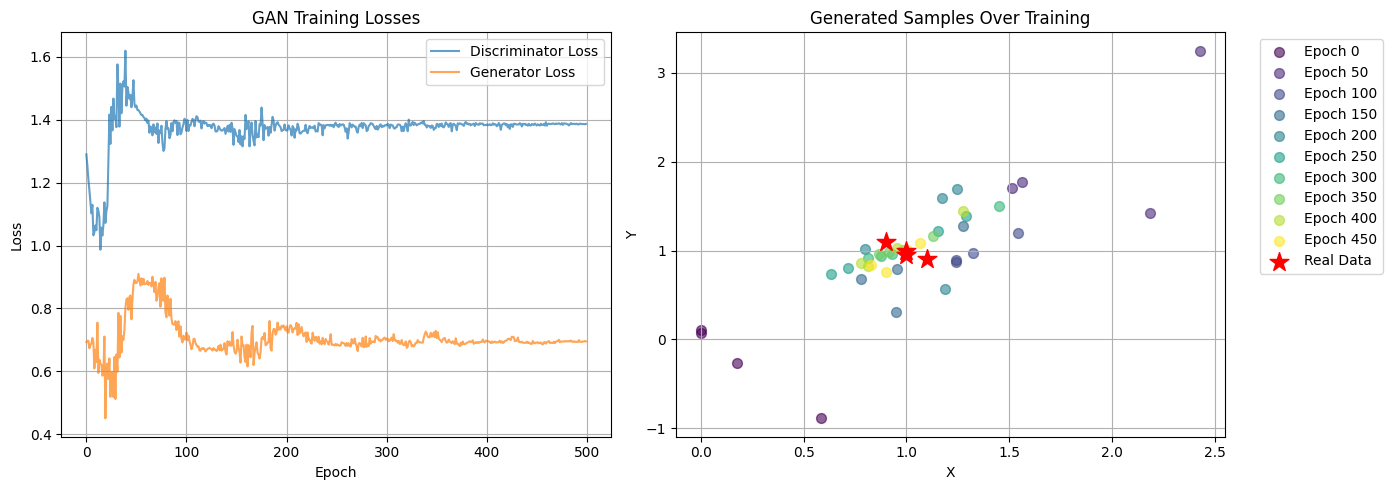

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot losses
axes[0].plot(D_losses, label='Discriminator Loss', alpha=0.7)
axes[0].plot(G_losses, label='Generator Loss', alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('GAN Training Losses')
axes[0].legend()
axes[0].grid(True)

# Plot generated samples evolution
colors = plt.cm.viridis(np.linspace(0, 1, len(fake_samples_history)))
for i, samples in enumerate(fake_samples_history):
    axes[1].scatter(samples[:, 0].numpy(), samples[:, 1].numpy(), 
                   c=[colors[i]], s=50, alpha=0.6, label=f'Epoch {i*50}')

axes[1].scatter(real_data[:, 0].numpy(), real_data[:, 1].numpy(), 
               c='red', s=200, marker='*', label='Real Data', zorder=10)
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].set_title('Generated Samples Over Training')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True)

plt.tight_layout()
plt.show()

Generated Samples:
  Sample 1: [0.936, 1.035]
  Sample 2: [0.877, 1.025]
  Sample 3: [0.905, 1.023]
  Sample 4: [0.791, 1.003]
  Sample 5: [1.254, 1.354]
  Sample 6: [0.974, 1.042]
  Sample 7: [0.909, 0.865]
  Sample 8: [0.871, 0.909]
  Sample 9: [0.937, 1.035]
  Sample 10: [0.782, 0.994]

Real data mean: [1.0, 0.987500011920929]
Generated mean: [0.9235164523124695, 1.0285416841506958]


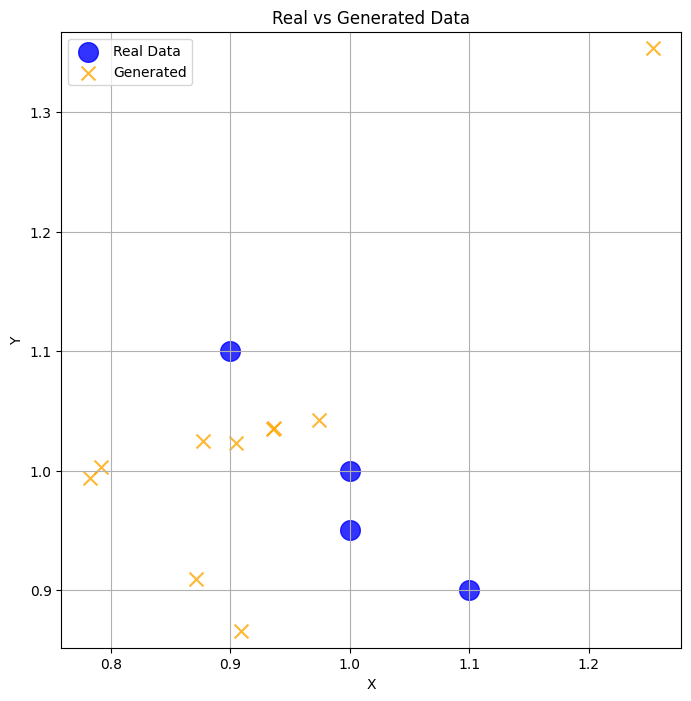


✓ Generator learned to produce data similar to real data!


In [9]:
# Generate new samples
n_samples = 10
z = torch.randn(n_samples, noise_dim)
generated = G.forward(z)

print("Generated Samples:")
print("="*40)
for i in range(n_samples):
    print(f"  Sample {i+1}: [{generated[i, 0].item():.3f}, {generated[i, 1].item():.3f}]")

print(f"\nReal data mean: {real_data.mean(dim=0).tolist()}")
print(f"Generated mean: {generated.mean(dim=0).tolist()}")

# Visualize
plt.figure(figsize=(8, 8))
plt.scatter(real_data[:, 0].numpy(), real_data[:, 1].numpy(), 
           c='blue', s=200, label='Real Data', marker='o', alpha=0.8)
plt.scatter(generated[:, 0].detach().numpy(), generated[:, 1].detach().numpy(), 
           c='orange', s=100, label='Generated', marker='x', alpha=0.8)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Real vs Generated Data')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

print("\n✓ Generator learned to produce data similar to real data!")

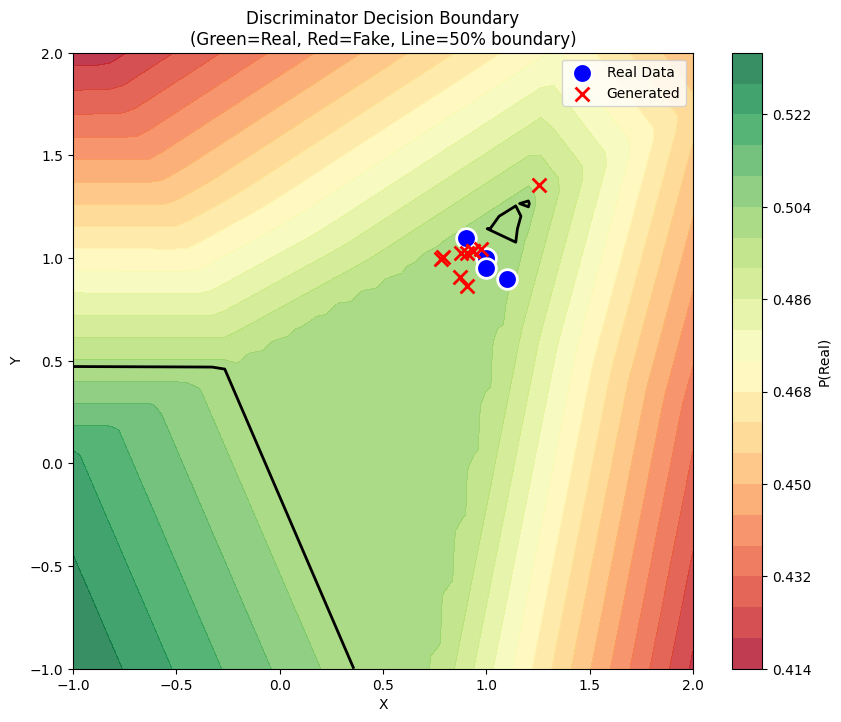

In [10]:
# Create grid
x_range = np.linspace(-1, 2, 50)
y_range = np.linspace(-1, 2, 50)
xx, yy = np.meshgrid(x_range, y_range)
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

# Get discriminator predictions
D_grid = D.forward(grid).detach().numpy().reshape(xx.shape)

# Plot
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, D_grid, levels=20, cmap='RdYlGn', alpha=0.8)
plt.colorbar(label='P(Real)')
plt.contour(xx, yy, D_grid, levels=[0.5], colors='black', linewidths=2)

plt.scatter(real_data[:, 0].numpy(), real_data[:, 1].numpy(), 
           c='blue', s=200, label='Real Data', marker='o', edgecolors='white', linewidth=2)
plt.scatter(generated[:, 0].detach().numpy(), generated[:, 1].detach().numpy(), 
           c='red', s=100, label='Generated', marker='x', linewidth=2)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Discriminator Decision Boundary\n(Green=Real, Red=Fake, Line=50% boundary)')
plt.legend()
plt.show()

In [11]:
print("GAN Adversarial Game:")
print("="*60)

# Generate samples
z = torch.randn(4, noise_dim)
fake = G.forward(z)

# Discriminator scores
D_real_scores = D.forward(real_data)
D_fake_scores = D.forward(fake)

print("\nReal Data:")
for i in range(len(real_data)):
    print(f"  {real_data[i].tolist()} -> D(x) = {D_real_scores[i].item():.4f}")

print("\nFake Data (from Generator):")
for i in range(len(fake)):
    print(f"  {fake[i].detach().tolist()} -> D(x) = {D_fake_scores[i].item():.4f}")

print(f"\nIdeal: D(real)=1.0, D(fake)=0.0")
print(f"After training: D(real)≈{D_real_scores.mean().item():.2f}, D(fake)≈{D_fake_scores.mean().item():.2f}")
print("\nNote: At equilibrium, discriminator can't tell them apart (both ≈ 0.5)!")

GAN Adversarial Game:

Real Data:
  [1.0, 1.0] -> D(x) = 0.4994
  [0.8999999761581421, 1.100000023841858] -> D(x) = 0.4996
  [1.100000023841858, 0.8999999761581421] -> D(x) = 0.4992
  [1.0, 0.949999988079071] -> D(x) = 0.4992

Fake Data (from Generator):
  [1.0157127380371094, 1.0548455715179443] -> D(x) = 0.4997
  [1.1108498573303223, 0.6447493433952332] -> D(x) = 0.4958
  [1.1777172088623047, 1.2576907873153687] -> D(x) = 0.5008
  [1.054905652999878, 1.0965687036514282] -> D(x) = 0.4999

Ideal: D(real)=1.0, D(fake)=0.0
After training: D(real)≈0.50, D(fake)≈0.50

Note: At equilibrium, discriminator can't tell them apart (both ≈ 0.5)!
